# TODO LIST

- [x] Choose Amsterdam / Rotterdam via parameter
- [ ] Add Lags for remaining districts
- [ ] Add / Replace `abs` values with `diff`
  - [x] Replace `lagged` variables with `diff`
  - [ ] Replace target variable with its `diff`
- [ ] Look-ahead values (e.g. 1 min 5 min 10 min 30 min) (tunable)
- [ ] Confusion Matrix per bin - find out model inaccuracies
- [ ] Add `LightGBM` model
- [ ] Benchmark accuracy, train-time, inference-time (in progress)
- [x] Add data from more than 1 days


In [1]:
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    f1_score,
    make_scorer,
)
from sklearn.model_selection import (
    GridSearchCV,
    TimeSeriesSplit,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBClassifier

from helper import cyclic_encode

In [2]:
df = pd.read_parquet("data/processed/points_per_district.parquet")

In [3]:
df = (
    df.pivot_table(
        index="timestamp", columns="district_id", values="crowd", aggfunc="sum"
    )
    .ffill()
    .bfill()
    .astype(np.uint16)
    .sort_values(by="timestamp")
    .reset_index()
)

df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")
df.head()

district_id,timestamp,Bedrijvenpark Noord-West,Botlek,Charlois,Delfshaven,Feijenoord,Hillegersberg-Schiebroek,Hoek van Holland,Hoogvliet,Kralingen-Crooswijk,Nieuw Mathenesse,Noord,Overschie,Pernis,Prins Alexander,Rotterdam Centrum,Spaanse Polder,Vondelingenplaat,Waalhaven,Ĳsselmonde
0,2024-06-18 06:21:58,18,1,327,520,496,513,15,4,621,62,391,37,1,238,732,46,1,10,225
1,2024-06-18 06:23:00,18,1,328,520,497,512,15,4,621,62,390,37,1,238,730,46,1,10,225
2,2024-06-18 06:24:02,18,1,329,519,498,512,15,4,622,62,391,37,1,238,732,46,1,10,225
3,2024-06-18 06:25:04,18,1,329,519,499,512,15,4,621,62,391,37,1,238,734,46,1,10,225
4,2024-06-18 06:26:07,18,1,329,517,499,515,15,4,620,62,391,37,1,238,733,46,1,10,225


Until more data comes and we have evenly distributed bins, we will work with the data up until 06-23 00:00:00


In [4]:
df = df.loc[df["timestamp"] < "2024-06-23 00:00:00"]

In [5]:
df.shape

(6537, 20)

## Feature Extraction

1. Binning
2. Time-related Features
   1. Extraction
      1. Hour
      2. Minute
      3. Day of week
   2. Cyclic Encoding
3. Lagged Features
   1. 1-10 Minutes
   2. 15 Minutes
   3. 30 Minutes
   4. 60 Minutes
4. Rolling Mean Features
   1. Mean
   2. Std
   3. Var
   4. Kurtosis
   5. Skewness
5. Exponential Smoothing Features
   1. 5 Minutes
   2. 10 Minutes
   3. 15 Minutes
   4. 30 Minutes
   5. 60 Minutes


##### Binning


In [6]:
target_district = "Rotterdam Centrum"
target_column_name = f'{target_district.replace(" ", "_")}_c_lvl'

mean_crowd = df[target_district].mean()
std_crowd = df[target_district].std()

# Define bins based on mean and standard deviation
bins = [
    float("-inf"),
    mean_crowd - 1.0 * std_crowd,
    mean_crowd - 0.5 * std_crowd,
    mean_crowd + 0.5 * std_crowd,
    mean_crowd + 1.0 * std_crowd,
    float("inf"),
]

# Define labels for the bins
labels = list(range(len(bins) - 1))

In [7]:
df[target_column_name] = pd.cut(
    df[target_district],
    bins=bins,
    labels=labels,
    include_lowest=True,
    ordered=True,
).astype(np.uint8)

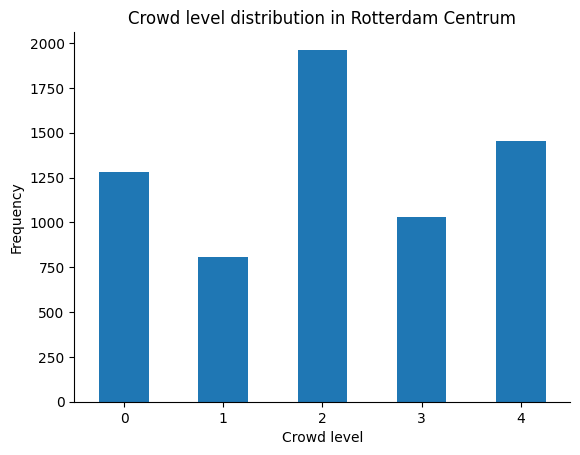

In [8]:
df[target_column_name].value_counts().sort_index().plot(
    kind="bar",
    rot=0,
    xlabel="Crowd level",
    ylabel="Frequency",
    title=f"Crowd level distribution in {target_district}",
)
plt.gca().spines[["top", "right"]].set_visible(False)
plt.show()

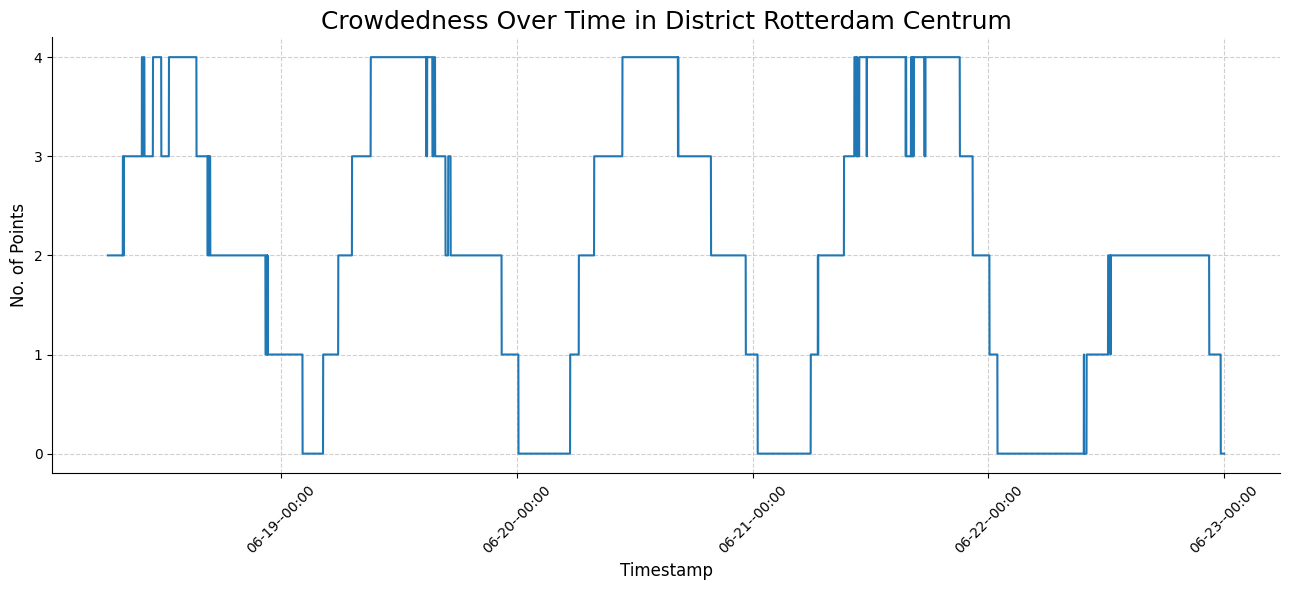

In [9]:
_, ax = plt.subplots(figsize=(13, 6))


ax.plot(
    df["timestamp"],
    df[target_column_name],
    linestyle="-",
    linewidth=1.5,
)

ax.set_title(f"Crowdedness Over Time in District {target_district}", fontsize=18)
ax.set_xlabel("Timestamp", fontsize=12)
ax.set_ylabel("No. of Points", fontsize=12)
plt.gca().spines[["top", "right"]].set_visible(False)
ax.grid(True, linestyle="--", alpha=0.6)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d--%H:%M"))

plt.xticks(rotation=45)
plt.yticks(df[target_column_name].unique())
plt.tight_layout()
# plt.savefig("figures/Crowdedness Bins.png", dpi=300)
plt.show()

Time-related Feature Extraction


In [10]:
# Time-related features
time_related_features = {
    "hour": df["timestamp"].dt.hour.astype(np.uint8),
    "day_of_week": df["timestamp"].dt.day_of_week.astype(np.uint8),
    "minute": df["timestamp"].dt.minute.astype(np.uint8),
    "is_weekend": (df["timestamp"].dt.weekday >= 5).astype(np.uint8),
}

Lagged and Rolling Feature Extraction


In [11]:
lagged_features = {}
rolling_features = {}
exp_smoothing_features = {}
windows = [5, 10, 15, 30] + [60 * i for i in range(1, 7)]  # + [60 * 24]
for district in df.columns[1:-1]:
    lagged_features.update(
        {
            f"{district.replace(' ', '_')}_lag_{i}": df[district].shift(i).diff()
            for i in list(range(1, 11)) + [15, 30, 60]
        }
    )

    rolling_features.update(
        {
            f"{district.replace(' ', '_')}_rolling_{stat}_{window}": getattr(
                df[target_district].rolling(window=window), stat
            )()
            for window in windows
            for stat in ["mean", "std", "var", "skew", "kurt"]
        }
    )

    exp_smoothing_features.update(
        {
            f"{district.replace(' ', '_')}_ema_{window}": df[target_district]
            .ewm(span=window, adjust=True)
            .mean()
            for window in windows
        }
    )

In [12]:
lagged_df = (
    pd.concat(
        [
            # After Feature Extraction we can drop the original target column
            df.drop(columns=target_district),
            pd.DataFrame(lagged_features),
            pd.DataFrame(rolling_features),
            pd.DataFrame(exp_smoothing_features),
            pd.DataFrame(time_related_features),
        ],
        axis=1,
    )
    .set_index("timestamp")
    .dropna()
)

lagged_df = cyclic_encode(lagged_df, "minute", 60)
lagged_df = cyclic_encode(lagged_df, "hour", 24)
lagged_df = cyclic_encode(lagged_df, "day_of_week", 7)

#### Data Splitting


In [13]:
X = lagged_df.drop(columns=target_column_name)
y = lagged_df[target_column_name]

In [14]:
X.shape, y.shape

((6178, 1412), (6178,))

#### Correlation Analysis


In [15]:
cm = X.select_dtypes(exclude=bool).corr().abs()
upper = cm.where(np.triu(np.ones(cm.shape), k=1).astype(bool))

high_corr = [col for col in upper.columns if any(upper[col] > 0.8)]
X.drop(columns=high_corr, inplace=True)

### Model Training

1. Pipeline Construction
2. Hyperparameter Tuning
3. Time Series Cross Validation


In [16]:
# Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

In [17]:
print(
    f"TRAIN: {X_train.shape}, {y_train.shape}, \nTEST: {X_test.shape}, {y_test.shape}"
)

TRAIN: (4942, 291), (4942,), 
TEST: (1236, 291), (1236,)


#### Pipeline Construction


In [18]:
num_features = X_train.select_dtypes(include=[np.float64]).columns.tolist()

In [19]:
def build_pipe(clf):
    preprocessor = ColumnTransformer(
        transformers=[
            ("scaler", StandardScaler(), num_features),
            ("one-hot", OneHotEncoder(handle_unknown="ignore"), ["is_weekend"]),
        ],
        remainder="passthrough",
    )

    # Define the pipeline
    return Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("estimator", clf),
        ]
    )


clf = XGBClassifier(random_state=42)

pipeline = build_pipe(clf)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['Bedrijvenpark_Noord-West_lag_1',
                                                   'Bedrijvenpark_Noord-West_lag_2',
                                                   'Bedrijvenpark_Noord-West_lag_3',
                                                   'Bedrijvenpark_Noord-West_lag_4',
                                                   'Bedrijvenpark_Noord-West_lag_5',
                                                   'Bedrijvenpark_Noord-West_lag_6',
                                                   'Bedrijvenpark_Noord-West_lag_7',
                                                   'Be...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

##### Grid Search


In [20]:
param_grid = {
    "estimator__n_estimators": [50, 100, 200],
    "estimator__max_depth": [2, 3],
    "estimator__learning_rate": [0.01, 0.05, 0.1],
    "estimator__colsample_bytree": [0.5, 0.7, 0.8],
    "estimator__reg_lambda": [0.3, 0.5, 0.7],
}

In [21]:
ts_cv = TimeSeriesSplit(n_splits=5)
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "f1_micro": make_scorer(f1_score, average="micro"),
}

In [22]:
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=ts_cv,
    scoring=scoring,
    refit="f1_micro",
    n_jobs=-1,
    verbose=1,
    error_score="raise",
)
grid_search.fit(X_train, y_train)

print(f"Best score: {grid_search.best_score_:.3f}")
print(f"Best parameters:")
for key, value in grid_search.best_params_.items():
    print(f"    - {key.split('__')[-1]}: {value}")

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best score: 0.523
Best parameters:
    - colsample_bytree: 0.5
    - learning_rate: 0.05
    - max_depth: 2
    - n_estimators: 50
    - reg_lambda: 0.5


In [23]:
for key, value in grid_search.cv_results_.items():
    (
        print(
            f"{key.replace('_', ' ').title()}: {value.mean():.3f} ± {value.std():.3f}"
        )
        if key.startswith(("mean_test", "test"))
        else None
    )

Mean Test Accuracy: 0.460 ± 0.031
Mean Test F1 Micro: 0.460 ± 0.031


In [24]:
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['Bedrijvenpark_Noord-West_lag_1',
                                                   'Bedrijvenpark_Noord-West_lag_2',
                                                   'Bedrijvenpark_Noord-West_lag_3',
                                                   'Bedrijvenpark_Noord-West_lag_4',
                                                   'Bedrijvenpark_Noord-West_lag_5',
                                                   'Bedrijvenpark_Noord-West_lag_6',
                                                   'Bedrijvenpark_Noord-West_lag_7',
                                                   'Be...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=2, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=50, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

## **Skip the next 2 cells**
***Experimental state below*** 

In [ ]:
cv_results = cross_validate(
    best_model,
    X_test,
    y_test,
    cv=ts_cv,
    scoring=scoring,
    error_score="raise",
)

In [ ]:
for key, value in cv_results.items():
    (
        print(
            f"{key.replace('_', ' ').title()}: {value.mean():.3f} ± {value.std():.3f}"
        )
        if key.startswith(("mean_test", "test"))
        else None
    )

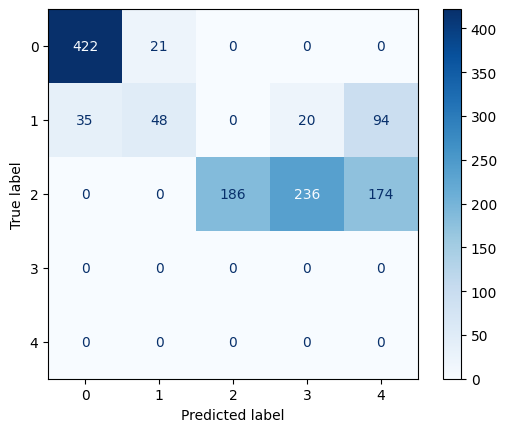

In [27]:
y_pred = best_model.predict(X_test)
_ = ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap="Blues")

In [28]:
print(
    classification_report(
        y_test,
        y_pred,
        digits=3,
        target_names=["very_low", "low", "medium", "high", "very_high"],
    )
)

              precision    recall  f1-score   support

    very_low      0.923     0.953     0.938       443
         low      0.696     0.244     0.361       197
      medium      1.000     0.312     0.476       596
        high      0.000     0.000     0.000         0
   very_high      0.000     0.000     0.000         0

    accuracy                          0.531      1236
   macro avg      0.524     0.302     0.355      1236
weighted avg      0.924     0.531     0.623      1236



/Users/tonytziorvas/Library/Caches/pypoetry/virtualenvs/lab-bvit9Y5v-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tonytziorvas/Library/Caches/pypoetry/virtualenvs/lab-bvit9Y5v-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tonytziorvas/Library/Caches/pypoetry/virtualenvs/lab-bvit9Y5v-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `ze